In [47]:
# Import necessary libraries
import os
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset, Subset, WeightedRandomSampler
from efficientnet_pytorch import EfficientNet
from PIL import Image
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from itertools import cycle

In [48]:
# Configuration
DATASET_PATH = "dataset"
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Ensure reproducibility for CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disables dynamic optimizations

set_seed(42)  # Call this before any model, dataset, or dataloader creation

# Battery type mapping
NUM_CLASSES = 5
battery_type_mapping = {
    "Lithium": "Lithium",
    "Li-Ion": "Li-ion",
    "Alkaline": "Alkaline",
    "Ni-Cd": "Ni-CD",
    "Ni-Mh": "Ni-MH",
}

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class BatteryTypeDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []
        self.label_map = {}
        self._prepare_dataset()

    def _prepare_dataset(self):
        battery_types = set()
        for brand_folder in os.listdir(self.root):
            brand_path = os.path.join(self.root, brand_folder)
            if os.path.isdir(brand_path):
                battery_type = battery_type_mapping[brand_folder]
                battery_types.add(battery_type)
        
        sorted_battery_types = sorted(battery_types)
        self.label_map = {bt: idx for idx, bt in enumerate(sorted_battery_types)}
        
        for brand_folder in os.listdir(self.root):
            brand_path = os.path.join(self.root, brand_folder)
            if os.path.isdir(brand_path):
                battery_type = battery_type_mapping[brand_folder]
                label = self.label_map[battery_type]
                for img_file in os.listdir(brand_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(brand_path, img_file)
                        self.samples.append((img_path, label))

    def get_class_distribution(self):
        class_counts = defaultdict(int)
        for _, label in self.samples:
            class_counts[label] += 1
        return class_counts

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        
        if image.mode in ('RGBA', 'LA') or (image.mode == 'P' and 'transparency' in image.info):
            if image.mode == 'P':
                image = image.convert('RGBA')
            
            background = Image.new('RGB', image.size, (255, 255, 255))
            
            if image.mode == 'RGBA':
                r, g, b, a = image.split()
                image = Image.merge('RGB', (r, g, b))
                mask = a
            elif image.mode == 'LA':
                l, a = image.split()
                image = Image.merge('L', (l,))
                image = image.convert('RGB')
                mask = a
            else:
                mask = None
            
            if mask and mask.mode == 'L':
                background.paste(image, mask=mask)
            else:
                background.paste(image)
            image = background
        else:
            image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

    def __len__(self):
        return len(self.samples)

# Dataset wrapper for applying transforms
class ApplyTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Load dataset
full_dataset = BatteryTypeDataset(DATASET_PATH, transform=None)

# Stratified split
labels = [label for _, label in full_dataset.samples]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(sss.split(np.zeros(len(labels)), labels))
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
valid_idx, test_idx = next(sss2.split(np.zeros(len(temp_idx)), [labels[i] for i in temp_idx]))

# Create subsets with transforms
train_subset = Subset(full_dataset, train_idx)
valid_temp_subset = Subset(full_dataset, [temp_idx[i] for i in valid_idx])
test_temp_subset = Subset(full_dataset, [temp_idx[i] for i in test_idx])

train_dataset = ApplyTransform(train_subset, transform=train_transform)
valid_dataset = ApplyTransform(valid_temp_subset, transform=val_transform)
test_dataset = ApplyTransform(test_temp_subset, transform=val_transform)

# Calculate class weights
class_dist = full_dataset.get_class_distribution()
class_counts = [class_dist[i] for i in range(len(class_dist))]
total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_dist) * count) for count in class_counts]
class_weights = torch.FloatTensor(class_weights).to(DEVICE)

# Weighted Random Sampler
train_sample_weights = [class_weights[label] for _, label in train_dataset]
train_sampler = WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
# Model definition
PRETRAINED_MODELS = {
    'resnet18': {
        'model': models.resnet18,
        'weights': models.ResNet18_Weights.IMAGENET1K_V1,
        'feature_dim': 512,
        'classifier_layer': 'fc'
    },
}

class BatteryClassifier(nn.Module):
    def __init__(self, model_name, num_classes=NUM_CLASSES, dropout_rate=0.5):
        super().__init__()

        # Ensure model_name exists in PRETRAINED_MODELS
        if model_name not in PRETRAINED_MODELS:
            raise ValueError(f"Model '{model_name}' is not supported. Choose from {list(PRETRAINED_MODELS.keys())}")

        self.model_config = PRETRAINED_MODELS[model_name]

        # Load pretrained model
        self.base_model = self.model_config['model'](weights=self.model_config['weights'])

        # Freeze all layers initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Unfreeze classifier/decoder layers
        self._unfreeze_decoder_layers(model_name)

        # Replace classifier
        self._build_classifier(num_classes, dropout_rate)

    def _unfreeze_decoder_layers(self, model_name):
        """Unfreezes specific layers for fine-tuning."""
        if 'resnet' in model_name:
            if hasattr(self.base_model, "layer3"):
                for param in self.base_model.layer3.parameters():
                    param.requires_grad = True
            if hasattr(self.base_model, "layer4"):
                for param in self.base_model.layer4.parameters():
                    param.requires_grad = True

    def _build_classifier(self, num_classes, dropout_rate):
        """Replaces the final classifier layer with a custom one."""
        in_features = self.model_config['feature_dim']

        classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(512, num_classes)
        )

        # Replace the classifier layer
        setattr(self.base_model, self.model_config['classifier_layer'], classifier)

    def forward(self, x):
        return self.base_model(x)

In [50]:
# Training function with early stopping
def train_model(model, optimizer, criterion, scheduler, train_loader, valid_loader, device, epochs, patience):
    best_valid_acc = 0.0
    no_improve = 0
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        valid_acc, valid_loss = validate_model(model, valid_loader, criterion, device, full_dataset)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        scheduler.step(valid_acc)
        
        # Early stopping
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
        print(f"Train Acc: {train_acc:.2f}% | Valid Acc: {valid_acc:.2f}%\n")
    
    return train_losses, valid_losses, train_accs, valid_accs

# Validation function
def validate_model(model, valid_loader, criterion, device, full_dataset):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            for label, pred in zip(labels, predicted):
                class_correct[label.item()] += (pred == label).item()
                class_total[label.item()] += 1
    
    print("Class-wise Validation Accuracy:")
    for class_idx in sorted(class_total):
        class_name = list(full_dataset.label_map.keys())[class_idx]
        acc = 100 * class_correct[class_idx] / class_total[class_idx]
        print(f"{class_name}: {acc:.2f}%")
    
    return 100 * correct / total, total_loss / len(valid_loader)

model = BatteryClassifier(model_name='resnet18').to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

print("Class distribution:", dict(full_dataset.get_class_distribution()))
print("Class weights:", class_weights.cpu().numpy())
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model, optimizer, criterion, scheduler,
    train_loader, valid_loader, DEVICE, EPOCHS, patience=3
)

Class distribution: {0: 183, 1: 88, 3: 36, 2: 37, 4: 40}
Class weights: [0.41967213 0.8727273  2.0756757  2.1333334  1.92      ]
Class-wise Validation Accuracy:
Alkaline: 66.67%
Li-ion: 57.14%
Lithium: 100.00%
Ni-CD: 100.00%
Ni-MH: 50.00%
Epoch [1/15]
Train Loss: 0.8017 | Valid Loss: 1.4920
Train Acc: 60.07% | Valid Acc: 68.97%

Class-wise Validation Accuracy:
Alkaline: 55.56%
Li-ion: 71.43%
Lithium: 60.00%
Ni-CD: 83.33%
Ni-MH: 66.67%
Epoch [2/15]
Train Loss: 0.3865 | Valid Loss: 2.3214
Train Acc: 79.48% | Valid Acc: 63.79%

Class-wise Validation Accuracy:
Alkaline: 25.93%
Li-ion: 78.57%
Lithium: 100.00%
Ni-CD: 66.67%
Ni-MH: 83.33%
Epoch [3/15]
Train Loss: 0.4374 | Valid Loss: 4.4908
Train Acc: 82.46% | Valid Acc: 55.17%

Class-wise Validation Accuracy:
Alkaline: 70.37%
Li-ion: 78.57%
Lithium: 80.00%
Ni-CD: 83.33%
Ni-MH: 83.33%
Epoch [4/15]
Train Loss: 0.3497 | Valid Loss: 1.8371
Train Acc: 79.85% | Valid Acc: 75.86%

Class-wise Validation Accuracy:
Alkaline: 40.74%
Li-ion: 92.86%
Lith

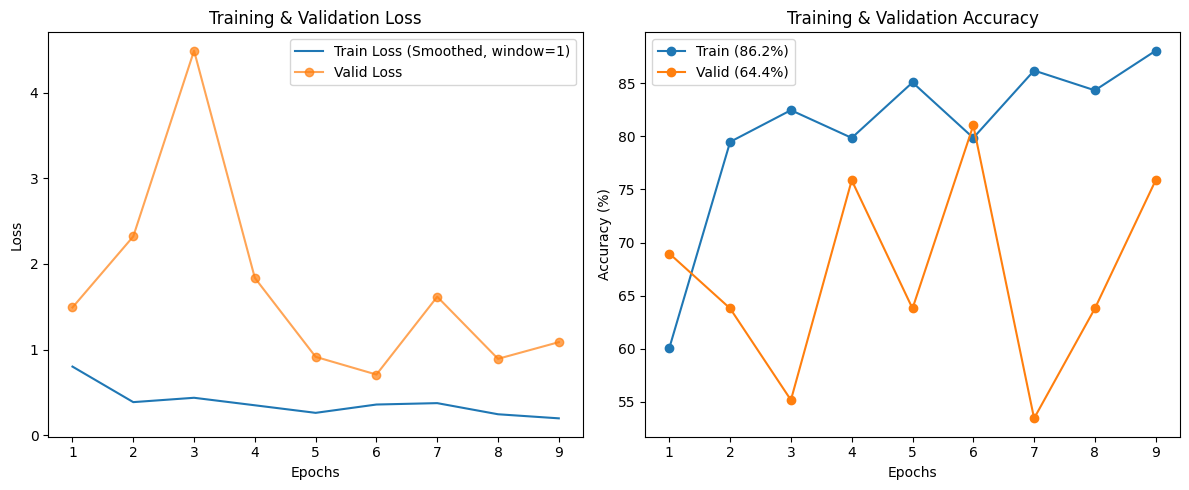

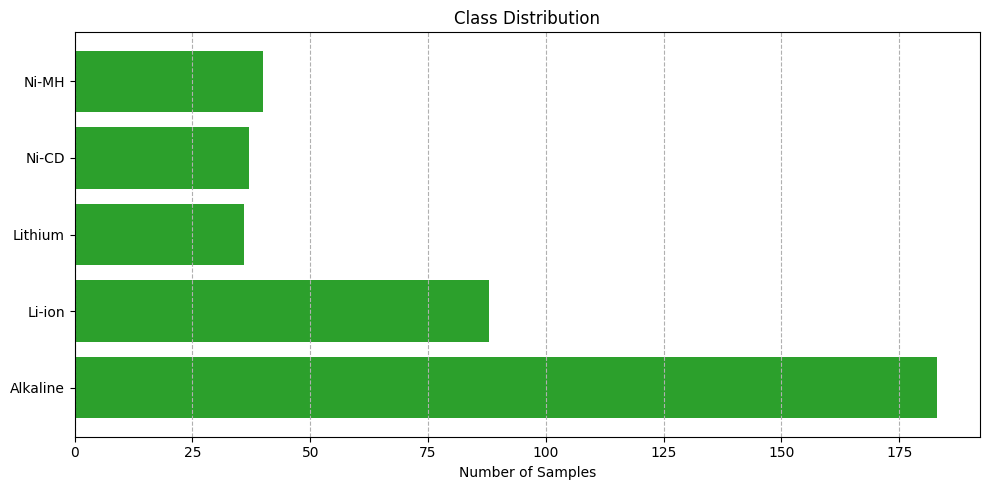


Classification Report:
              precision    recall  f1-score   support

    Alkaline      0.926     0.893     0.909        28
      Li-ion      0.800     0.923     0.857        13
     Lithium      0.750     1.000     0.857         6
       Ni-CD      1.000     0.800     0.889         5
       Ni-MH      1.000     0.667     0.800         6

    accuracy                          0.879        58
   macro avg      0.895     0.857     0.862        58
weighted avg      0.894     0.879     0.879        58



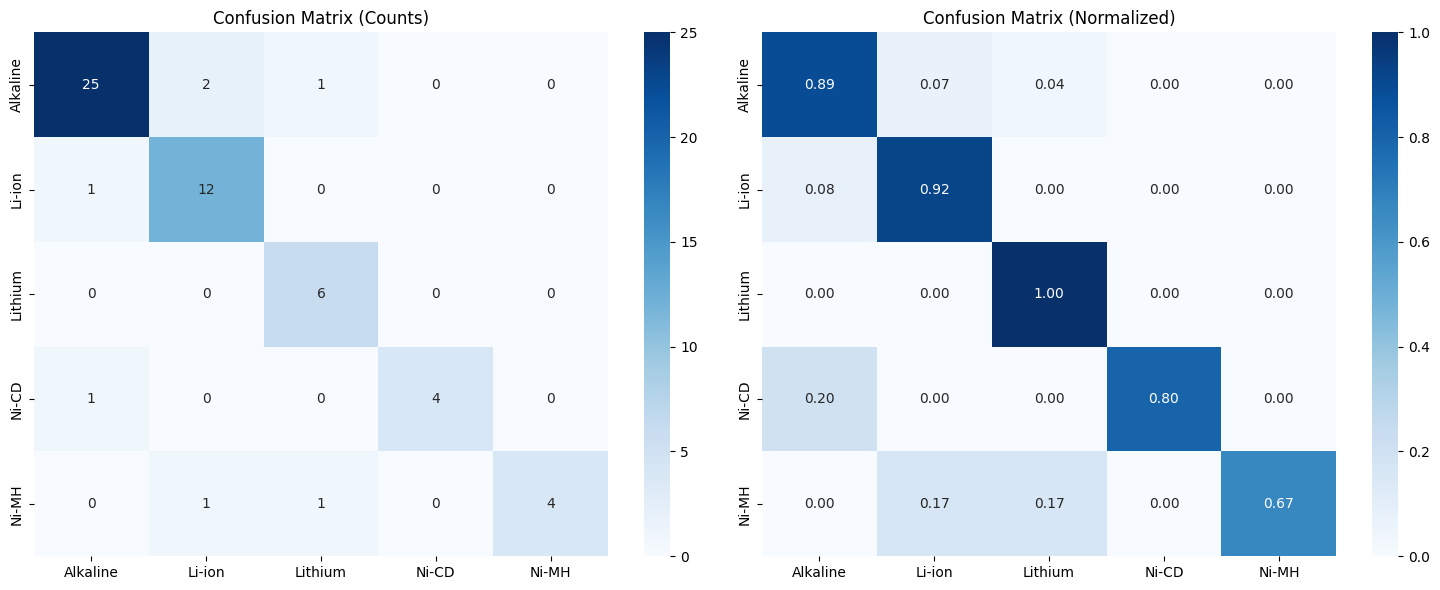

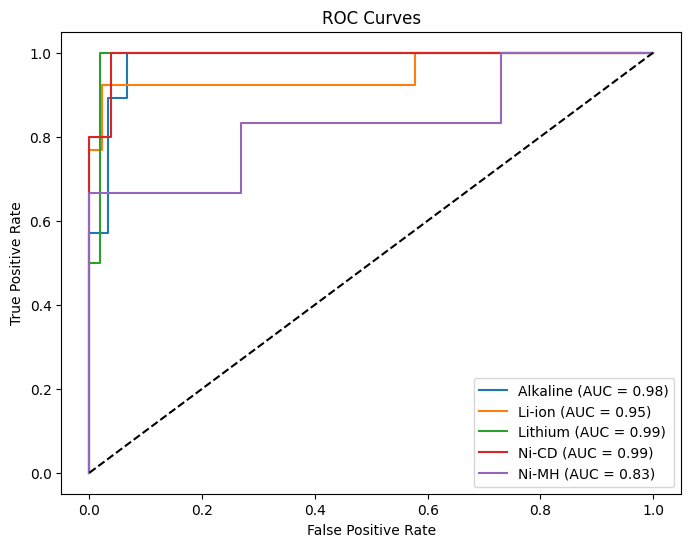

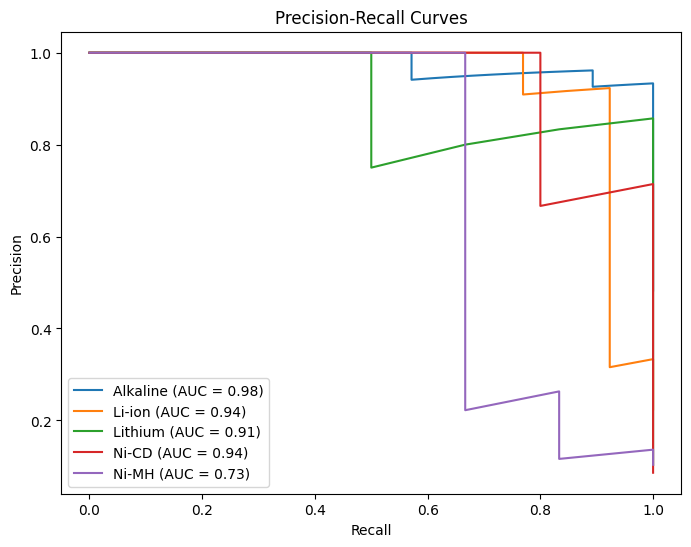

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13083315..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.6530111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.555955].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33633018..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.82].
Clipping in

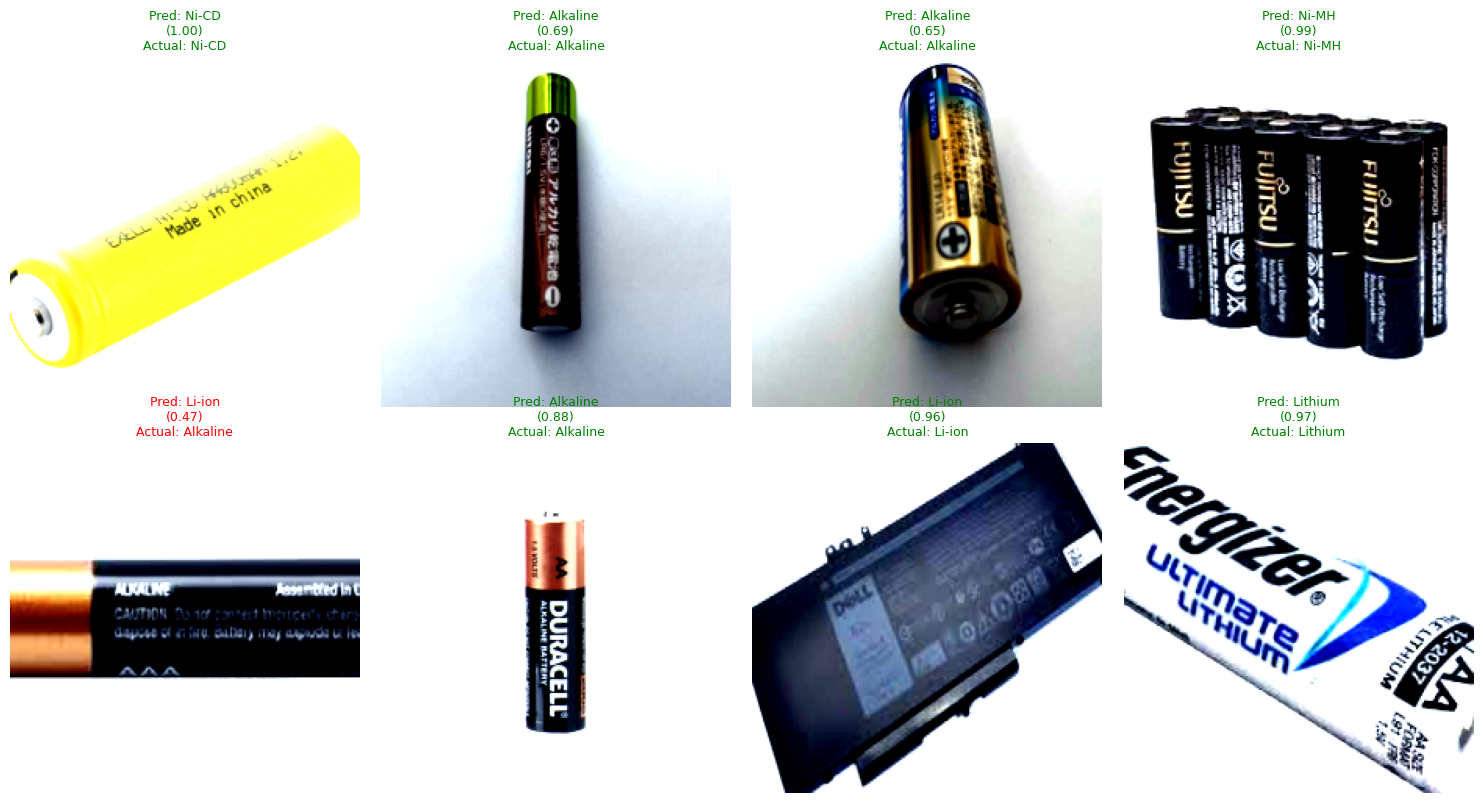

Class-wise Validation Accuracy:
Alkaline: 89.29%
Li-ion: 92.31%
Lithium: 100.00%
Ni-CD: 80.00%
Ni-MH: 66.67%

Final Test Accuracy: 87.93% | Test Loss: 0.5383


In [51]:

# Visualization functions
def plot_results(train_losses, valid_losses, train_accs, valid_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Loss Plot with proper smoothing
    plt.subplot(1, 2, 1)
    smooth_window = max(1, len(train_losses)//10)
    smooth_train_loss = np.convolve(train_losses, np.ones(smooth_window)/smooth_window, mode='valid')
    plt.plot(range(1, len(smooth_train_loss)+1), smooth_train_loss, 
             label=f"Train Loss (Smoothed, window={smooth_window})")
    plt.plot(epochs, valid_losses, label="Valid Loss", marker="o", alpha=0.7)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    
    # Accuracy Plot with final values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label=f"Train ({np.mean(train_accs[-3:]):.1f}%)", marker="o")
    plt.plot(epochs, valid_accs, label=f"Valid ({np.mean(valid_accs[-3:]):.1f}%)", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                               target_names=class_names, 
                               digits=3))

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix (Counts)")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix (Normalized)")
    plt.tight_layout()
    plt.show()

    # ROC and PR curves
    n_classes = len(class_names)
    colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    
    # ROC Curve
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i), np.array(y_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=next(colors),
                 label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve((np.array(y_true) == i), np.array(y_probs)[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, color=next(colors),
                 label=f'{class_names[i]} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.show()

def plot_class_distribution(dataset):
    class_counts = list(dataset.get_class_distribution().values())
    class_names = list(dataset.label_map.keys())
    
    plt.figure(figsize=(10, 5))
    plt.barh(class_names, class_counts, color='#2ca02c')
    plt.title("Class Distribution")
    plt.xlabel("Number of Samples")
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

def show_sample_predictions(model, test_loader, class_names, device, num_images=8):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_images].to(device), labels[:num_images]
    
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = outputs.max(1)

    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    images = (images * 0.5) + 0.5  # Unnormalize

    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        prob = probs[i][preds[i]].item()
        title = f"Pred: {class_names[preds[i]]}\n({prob:.2f})\nActual: {class_names[labels[i]]}"
        color = "green" if preds[i] == labels[i] else "red"
        plt.title(title, color=color, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(DEVICE)

class_names = list(full_dataset.label_map.keys())
plot_results(train_losses, valid_losses, train_accs, valid_accs)
plot_class_distribution(full_dataset)
plot_confusion_matrix(model, test_loader, class_names, DEVICE)
show_sample_predictions(model, test_loader, class_names, DEVICE)

# Final test evaluation
test_acc, test_loss = validate_model(model, test_loader, criterion, DEVICE, full_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")